In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, jarque_bera, anderson
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay



In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
df = pd.read_csv('../../data/data.csv')
print(df.columns)
print(df.info())
# -----------------------------
# Features base (única fuente de verdad)
# -----------------------------
features_kmeans = [
    'Age',
    'PlayTimeHours',
    'SessionsPerWeek',
    'AvgSessionDurationMinutes',
    'InGamePurchases'
]

# -----------------------------
# 1) K-Means + PCA
# -----------------------------
X_km = df[features_kmeans].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_km)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=100,
    random_state=42
)

df['Cluster_PCA'] = kmeans.fit_predict(X_pca)

# -----------------------------
# 2) One-hot del cluster
# -----------------------------
X_cluster = pd.get_dummies(df['Cluster_PCA'], prefix='cluster')

# -----------------------------
# 3) DataFrame FINAL para entrenamiento
# -----------------------------
X = pd.concat(
    [
        df[features_kmeans].reset_index(drop=True),
        X_cluster.reset_index(drop=True)
    ],
    axis=1
)

y = df['EngagementLevel'].map({'Low': 0, 'Medium': 1, 'High': 2})

# -----------------------------
# 4) Comprobaciones
# -----------------------------
print("Columnas de X:")
print(X.columns)

print("\nInfo de X:")
print(X.info())



Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSe

In [3]:
y.value_counts(normalize=True)

EngagementLevel
1    0.483939
2    0.258181
0    0.257881
Name: proportion, dtype: float64

              precision    recall  f1-score   support

         Low       0.67      0.81      0.73      3069
      Medium       0.86      0.70      0.77      5810
        High       0.79      0.90      0.84      3132

    accuracy                           0.78     12011
   macro avg       0.77      0.80      0.78     12011
weighted avg       0.79      0.78      0.78     12011

Accuracy: 77.89%
Precision: 79.13%
Recall: 77.89%
F1-Score: 77.87%


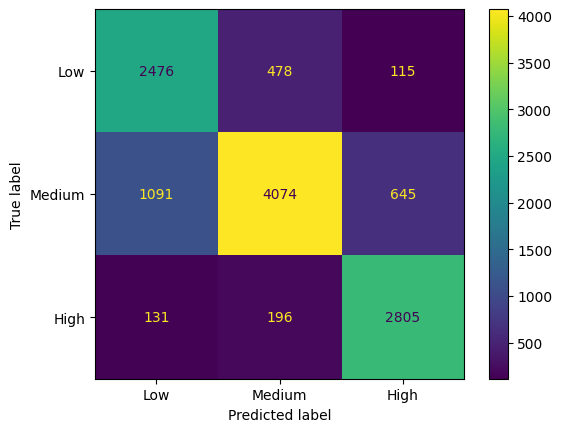

In [4]:
# Dividimos el dataset en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Estandarizamos los datos
escaler = StandardScaler()
X_train = escaler.fit_transform(X_train)
X_test = escaler.transform(X_test)

#Crear el modelo de regresión logística multinomial 
model = LogisticRegression(solver='lbfgs', max_iter=2000,
    class_weight="balanced") # multinomial es para problemas de clasificación multiclase

# Entrenamos el modelo
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)

# Mostramos el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Low','Medium','High'])) 

# Calcular métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

 
# Matriz de confusión
matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Low','Medium','High'])

plt.show()

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# --------------------
# MÉTODO 2: Ajuste automático con GridSearchCV
# --------------------
parametros = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Diferentes valores de regularización
    "solver": ["liblinear", "lbfgs"]  # Diferentes algoritmos de optimización
}

# Configurar GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=500), parametros, cv=5, scoring="f1_macro", n_jobs=-1)

grid_search.fit(X_train, y_train)  # Entrenar búsqueda de hiperparámetros

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predicciones del mejor modelo
y_pred_best = best_model.predict(X_test)

# Evaluación del mejor modelo
print("\nResultados con ajuste automático de hiperparámetros:")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en validación cruzada: {grid_search.best_score_ * 100:.2f}%")
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')
accuracy = accuracy_score(y_test, y_pred_best)

# Mostrar las métricas
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")



Resultados con ajuste automático de hiperparámetros:
Mejores parámetros: {'C': 1, 'solver': 'lbfgs'}
Mejor Accuracy en validación cruzada: 81.39%
Accuracy: 81.86%
Precision: 82.05%
Recall: 81.86%
F1-Score: 81.73%


c:\Users\dekna\OneDrive\Escritorio\Bluetab_case\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dekna\OneDrive\Escritorio\Bluetab_case\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dekna\OneDrive\Escritorio\Bluetab_case\.venv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\dekna\OneDrive\

Puedes decir:

“Estas variables empujan al modelo hacia High engagement…”